In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [2]:
dpath = "./data/"
df = pd.read_csv(dpath + "mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

<AxesSubplot:xlabel='gill-color', ylabel='count'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


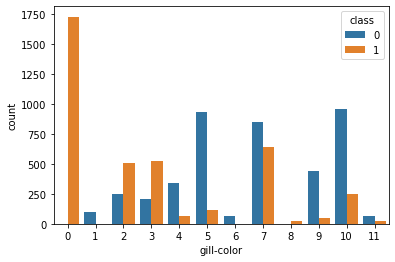

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in df.columns:
    df[col] = labelencoder.fit_transform(df[col])
df.head()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.countplot(x="gill-color", hue="class",data=df)

In [5]:
#数据集是一个文件，我们自己分出一部分来做测试吧（不是校验集）
y = df['class']
X = df.drop('class', axis = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
columns = X_train.columns
#体验一下分裂及gini 计算
df1 = pd.DataFrame({'gill-color':X_train['gill-color'], 'class':y_train})
df1.sort_values(by=['gill-color'],ascending=True)
gini=[]
for i in range(11) :
    threshold = i + 0.5
    dl = df[df['gill-color'] <= threshold]
    dr = df[df['gill-color'] > threshold]
    dl_0 = (dl['class'] == 0).sum()
    dl_1 = (dl['class'] == 1).sum()
    dr_0 = (dr['class'] == 0).sum()
    dr_1 = (dr['class'] == 1).sum()
    total_l = dl_0 + dl_1
    total_r = dr_0 + dr_1
    total = total_l + total_r
    h_l = 2.0 * dl_0/total_l * dl_1/total_l
    h_r = 2.0 * dr_0/total_r * dr_1/total_r
    gini.append(h_l*total_l/total + h_r*total_r/total)
print(gini)

[0.3543844641946022, 0.3739663947329344, 0.3621154280725757, 0.32883812359574915, 0.36911839170001565, 0.4482379747002899, 0.452776520958944, 0.4501570405964006, 0.4473229852206424, 0.47107276743242, 0.49825903532938304]


The AUC of default Desicion Tree is 1.0


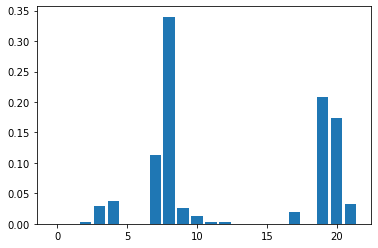

In [6]:
#默认参数的决策树
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
y_prob = model_tree.predict_proba(X_test)[:,1]
# This will give you positive class prediction probabilities
y_pred = np.where(y_prob > 0.5, 1, 0) 
# This will threshold the probabilities to give class predictions.
model_tree.score(X_test, y_pred)
print ('The AUC of default Desicion Tree is', roc_auc_score(y_test,y_pred))
df = pd.DataFrame({"columns":list(columns), "importance":list(model_tree.feature_importances_.T)})
df.sort_values(by=['importance'],ascending=False)
plt.bar(range(len(model_tree.feature_importances_)), model_tree.feature_importances_)
plt.show()

In [7]:
#超参数调优
from sklearn.tree import DecisionTreeClassifier
model_DD = DecisionTreeClassifier()
max_depth = range(3,10,1)
min_samples_leaf = range(5,15,1)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [8]:
from sklearn.model_selection import GridSearchCV
gird = GridSearchCV(model_DD, tuned_parameters, scoring='roc_auc',cv=10)
gird.fit(X_train, y_train)
print("Best: %f using %s" % (gird.best_score_, gird.best_params_))
y_prob = gird.best_estimator_.predict_proba(X_test)[:,1]
# This will give you positive class prediction probabilities
y_pred = np.where(y_prob > 0.5, 1, 0)
# This will threshold the probabilities to give class predictions.
gird.score(X_test, y_pred)

Best: 1.000000 using {'max_depth': 7, 'min_samples_leaf': 5}


1.0

In [9]:
print ('The AUC of GridSearchCV Desicion Tree is', roc_auc_score(y_test,y_pred))
import graphviz
import pydotplus
from sklearn import tree
#dotfile = StringIO.StringIO()
dot_data = tree.export_graphviz(gird.best_estimator_, out_file='best_tree.dot',feature_names=columns, class_names='class',)
!dot -Tpng best_tree.dot -o best_tree.png

The AUC of GridSearchCV Desicion Tree is 1.0
